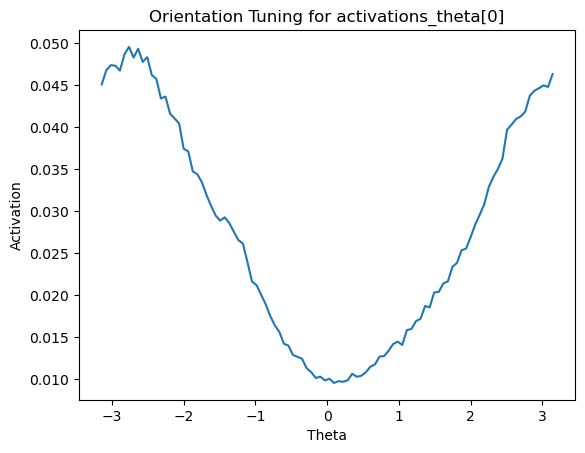

In [27]:
import numpy as np
import matplotlib.pyplot as plt
res = 50
activations_theta = np.load('activations_theta.npy')

# 绘制orientation tuning
theta = np.linspace(-np.pi, np.pi, res*2)
i = 0
plt.figure()
plt.plot(theta, activations_theta[i])
plt.title(f'Orientation Tuning for activations_theta[{i}]')
plt.xlabel('Theta')
plt.ylabel('Activation')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy.optimize import curve_fit

def band_score(rate,res):
    X,Y = np.meshgrid(np.linspace(-2,2,res),np.linspace(-2,2,res))
    x_flat,y_flat = X.flatten(), Y.flatten()
    loc = np.stack([x_flat,y_flat])

    # 计算频谱
    def spectrum(ratemap):
        res = ratemap.shape[0]
        fft_rate = np.abs(nf.fftshift(nf.fft2(ratemap)))
        fft_rate[:int(res/2),:] = 0
        return fft_rate
    ratemap = rate.reshape(res,res)
    fft_rate = spectrum(ratemap)

    # 定义高斯函数
    def gaussian(loc, A, k, phi, sigma):
        x = loc[0]
        y = loc[1]
        return A * np.exp(-((x - k*np.cos(phi))**2 / (2 * sigma**2) + (y - k*np.sin(phi))**2 / (2 * sigma**2)))

    initial_guess = [1.0, 0.2, 0.0, 0.1]

    try:
        params, _ = curve_fit(lambda xy, A, k, phi, sigma: gaussian(xy, A, k, phi, sigma), 
                                (loc), 
                                fft_rate.ravel(), 
                                p0=initial_guess, 
                                bounds=([0, 0.2, 0, 0.05], [np.inf, 1, np.pi, 0.5]),
                                maxfev=1000)  # 增加最大函数评估次数
    except RuntimeError as e:
        # print("Warning:", e)
        # 使用 `full_output=True` 调用 leastsq 获取最后一步的参数
        from scipy.optimize import leastsq
        params, _, _, _, _ = leastsq(
            lambda xy: fft_rate.ravel() - gaussian(loc, *xy), initial_guess or np.ones(len(initial_guess)), full_output=True, maxfev=1000
        )
        # print("Returning last known parameters:", params)
    # return popt, pcov
    dx = 4.4/res
    k0 = params[1]
    phi = params[2]
    sigma = params[3]
    kx = k0*np.cos(phi)/2*(1/dx/2)*np.pi*2
    ky = k0*np.sin(phi)/2*(1/dx/2)*np.pi*2
    k = np.sqrt(kx**2+ky**2)# The maximum frequency is 1/dx, correspoding k = np.pi*2/dx
    # print(params)
    gx = gaussian(loc, params[0], params[1], params[2], params[3])

    # 计算相关性
    band_scores = np.dot(fft_rate.ravel(), gx.ravel()) / (1e-8+np.linalg.norm(fft_rate.ravel()) * np.linalg.norm(gx.ravel())) / sigma

    return band_scores, ratemap, params, fft_rate, gx, k, phi, sigma


In [29]:
from tqdm import tqdm
import numpy as np

res = 50

data = np.load('rate_map.npy')
print(data.shape)
Ng = data.shape[0]
T = data.shape[1]
score = np.zeros(Ng,)
k = np.zeros(Ng,)
phi = np.zeros(Ng,)
sigma = np.zeros(Ng,)
ratemap = np.zeros([Ng,50,50])
for i in tqdm(range(Ng)):
    rate = data[i]-np.mean(data[i])
    band_scores, rm, params, fft_rate, gx, k[i], phi[i], sigma[i] = band_score(rate,res)
    ratemap[i] = rm
    score[i] = band_scores

(4096, 2500)


100%|██████████| 4096/4096 [00:51<00:00, 80.30it/s] 


Text(0.5, 1.0, 'band score distribution')

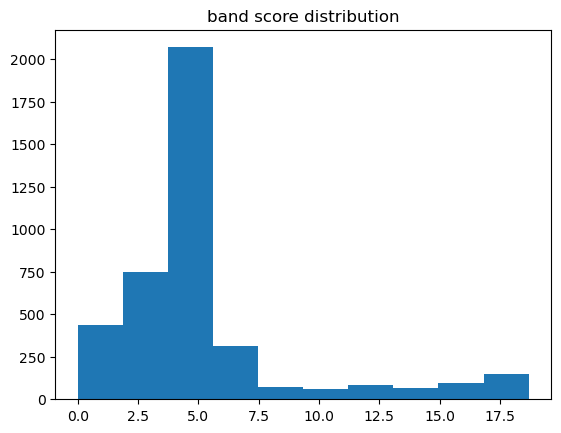

In [30]:
plt.hist(score)
plt.title('band score distribution')

selected cell number: 505


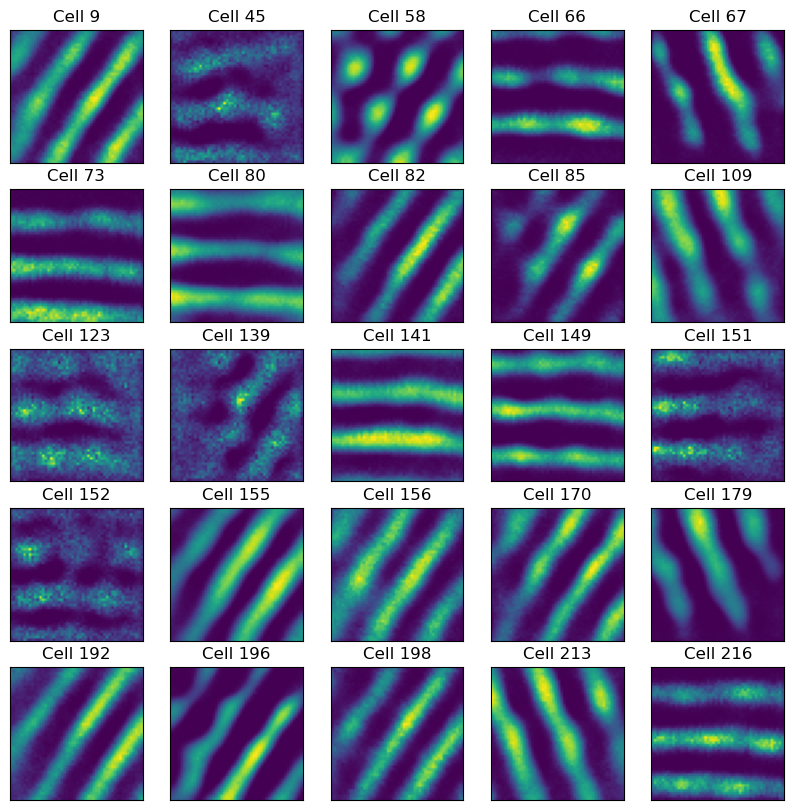

In [31]:
# 绘制place tuning
score_thres = 8.0

index = np.argsort(-score)
n_sub = 5
fig,ax = plt.subplots(n_sub,n_sub,figsize=(10,10))
# print(score[index[800]])
index_band = np.where(score>score_thres)[0]
# index_band = np.
print('selected cell number:',index_band.shape[0])

# print(len(index_band))
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].set_title(f'Cell {index_band[i]}')
    ax[x,y].imshow(ratemap[index_band[i]])
    ax[x, y].set_xticks([])  # Remove x-axis ticks
    ax[x, y].set_yticks([])  # Remove y-axis ticks
    ax[x, y].tick_params(axis='both', which='both', length=0) 
    # ax.set_ticks
plt.savefig('place_tuning.png')

selected cell number: 505


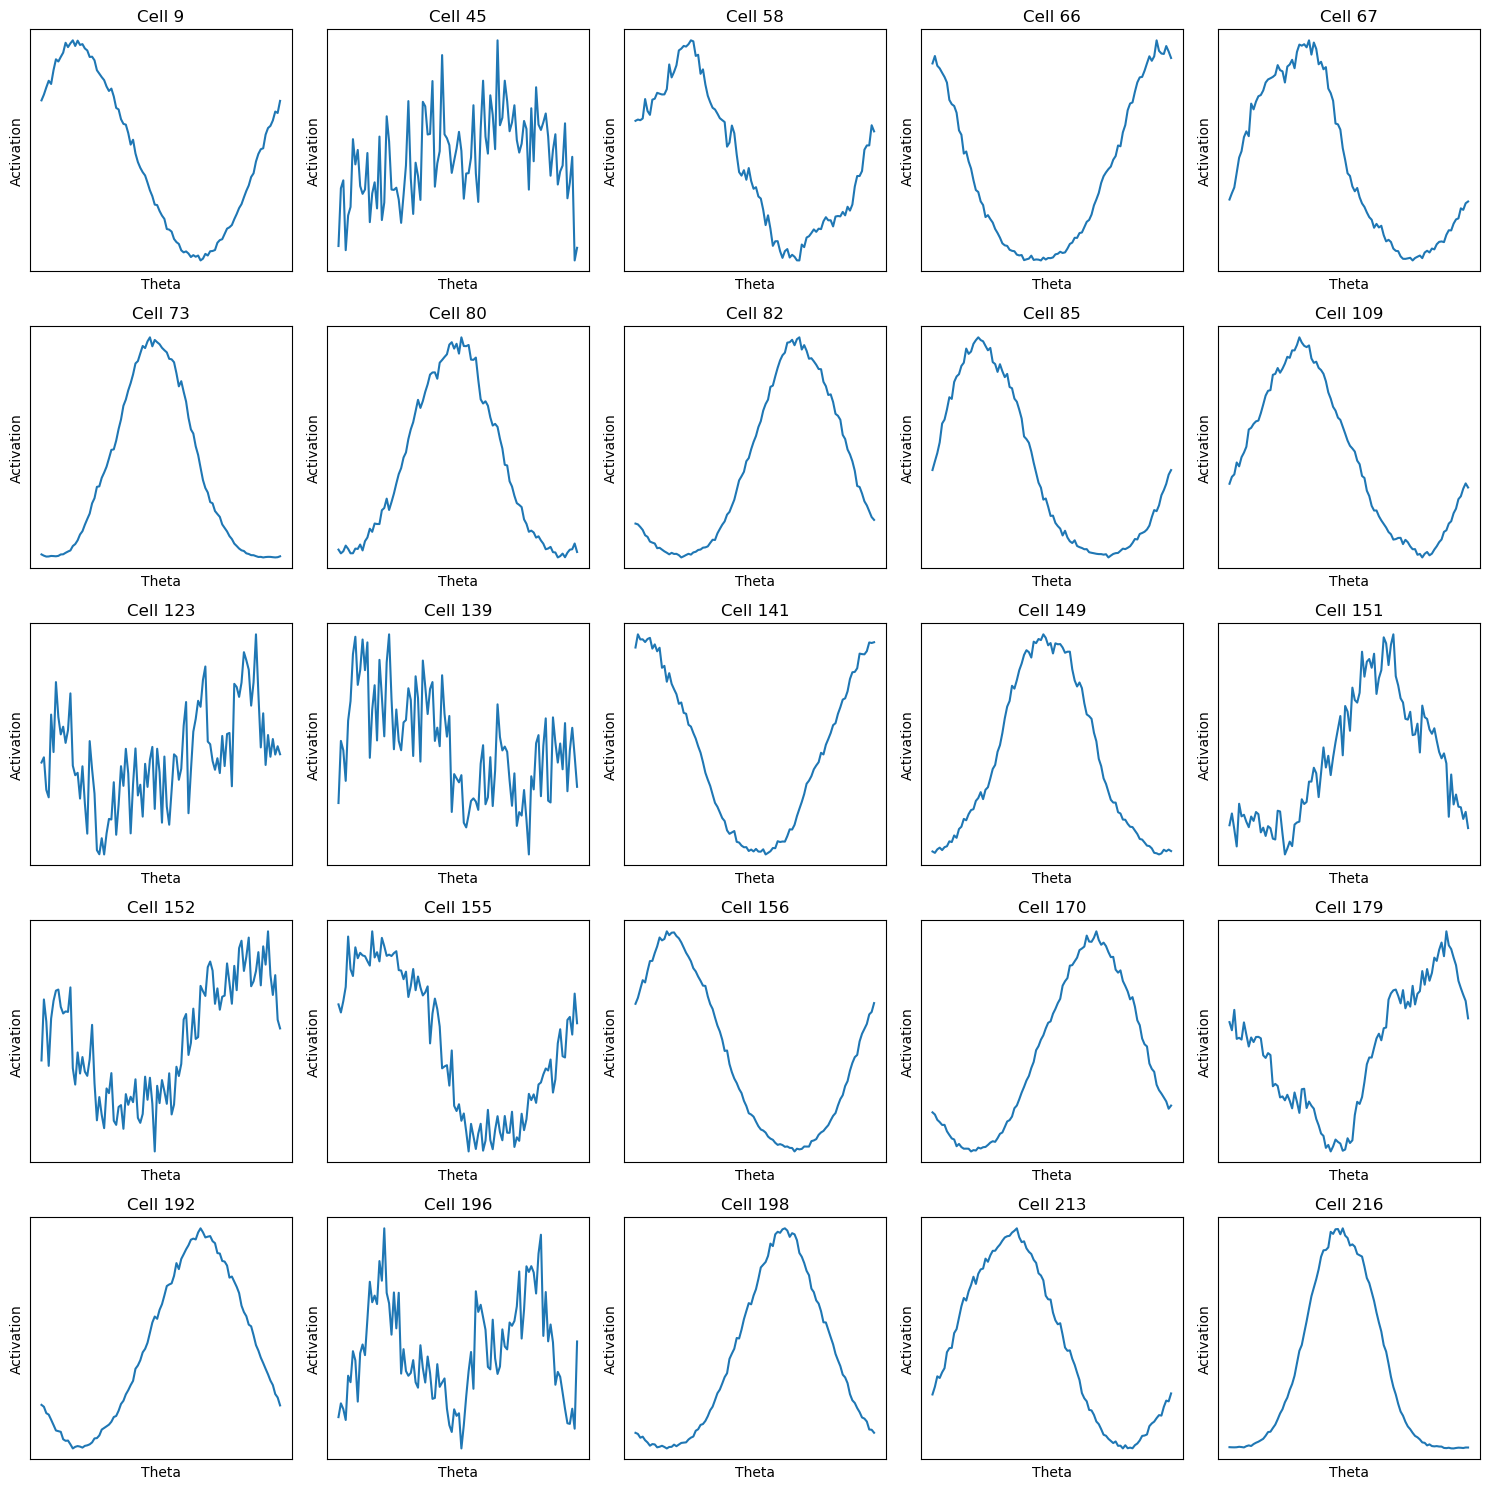

In [32]:

# 绘制orientation tuning
score_thres = 8.0

index = np.argsort(-score)
n_sub = 5
fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))
index_band = np.where(score > score_thres)[0]
print('selected cell number:', index_band.shape[0])

theta = np.linspace(-np.pi, np.pi, res * 2)
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].plot(theta, activations_theta[index_band[i]])
    ax[x, y].set_title(f'Cell {index_band[i]}')
    ax[x, y].set_xlabel('Theta')
    ax[x, y].set_ylabel('Activation')
    ax[x, y].set_xticks([])  # Remove x-axis ticks
    ax[x, y].set_yticks([])  # Remove y-axis ticks
    ax[x, y].tick_params(axis='both', which='both', length=0) 

plt.tight_layout()
plt.savefig('dir_tuning.png')
plt.show()

In [33]:
# direction score
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    dis = np.where(np.abs(x-mu)<np.pi,np.abs(x-mu),np.pi*2-np.abs(x-mu))
    return A * np.exp(-dis**2 / (2 * sigma**2))

def direction_scores(activations_theta=activations_theta, Ng=Ng):
    scores = []
    A_params = []
    mu_params = []
    sigma_params = []
    theta = np.linspace(-np.pi, np.pi, activations_theta.shape[1])
    
    for i in range(Ng):
        y_data = activations_theta[i]
        
        # Fit the Gaussian function to the data
        try:
            popt, _ = curve_fit(gaussian, theta, y_data, p0=[1, 0, 1])
            fitted_curve = gaussian(theta, *popt)
            
            # Calculate cosine similarity
            cos_sim = np.dot(y_data, fitted_curve) / (np.linalg.norm(y_data) * np.linalg.norm(fitted_curve))
            scores.append(cos_sim)
            
            # Save the parameters
            A_params.append(popt[0])
            mu_params.append(popt[1])
            sigma_params.append(popt[2])
        except RuntimeError:
            scores.append(0)
            A_params.append(0)
            mu_params.append(0)
            sigma_params.append(0)
    
    return np.array(scores), np.array(A_params), np.array(mu_params), np.array(sigma_params)

direction_scores, A_params, mu_params, sigma_params = direction_scores()

/Users/chutianhao/opt/miniconda3/envs/brainpy/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_67894/1119230856.py:24: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = np.dot(y_data, fitted_curve) / (np.linalg.norm(y_data) * np.linalg.norm(fitted_curve))
/Users/chutianhao/opt/miniconda3/envs/brainpy/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


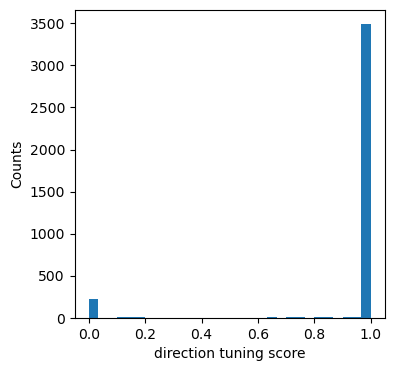

In [34]:
plt.figure(figsize=(4,4))
plt.hist(direction_scores,bins=30)
plt.xlabel('direction tuning score')
plt.ylabel('Counts')
plt.savefig('dir_tuning_score.png')

In [2]:
import numpy as np
# 绘制direction比较高的orientation tuning
score_thres = 8.0
index = np.argsort(-score)
index_direction = np.where((direction_scores > 0.9) & (A_params > 0.01) & (np.abs(sigma_params) < 4))[0]
index_band = np.intersect1d(index_direction, np.where(score > score_thres)[0])

n_sub = 5
fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))
print('selected cell number:', index_band.shape[0])

theta = np.linspace(-np.pi, np.pi, res * 2)
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].plot(theta, activations_theta[index_band[i]])
    ax[x, y].set_title(f'Cell {index_band[i]}')
    ax[x, y].set_xlabel('Theta')
    ax[x, y].set_ylabel('Activation')


NameError: name 'score' is not defined

4096


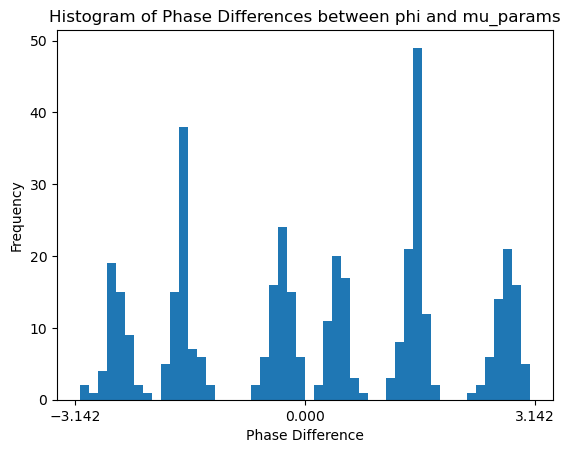

In [44]:
# 计算phi和mu的相位差
print(mu_params.shape[0])
phase_diff = phi[index_band] - mu_params[index_band] 
phase_diff = np.where(phase_diff>np.pi,phase_diff-np.pi*2,phase_diff)
phase_diff = np.where(phase_diff<-np.pi,phase_diff+np.pi*2,phase_diff)
plt.hist(phase_diff, bins=50)
plt.xticks([-np.pi,0,np.pi])
plt.xlabel('Phase Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Phase Differences between phi and mu_params')
plt.show()